# 多 Agent 协作自动修复 K8s 故障

1. 管理员 Agent
2. 自动修复 Agent
3. 寻求人类帮助 Agent
4. 网络搜索 Agent
5. 执行代码 Agent

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

In [2]:
# 导入环境变量
import getpass
import os

# 定义函数，设置未定义的环境变量
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# 设置 OPENAI API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

import time
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# 初始化两个工具
tavily_tool = TavilySearchResults(max_results=5)
# 执行 Python 代码的工具，谨慎使用
python_repl_tool = PythonREPLTool()


In [3]:
# 定义消息 Agent 的节点
from langchain_core.messages import HumanMessage

# 定义一个消息代理节点，把结果封装成 HumanMessage 类型
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [5]:
# 定义 supervisor Agent 和调度逻辑
# 管理员 Agent，负责决定下一个由哪个 Agent 来执行任务

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal,Sequence
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

# 定义成员 Agent 和系统提示语，告诉 supervisor 要负责调度多个 Agent
members = ["Researcher","Coder","AutoFixK8s","HumanHelp"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members

# 定义 supervisor 的响应类，选择下一个执行的 Agent
class routeResponse(BaseModel):
    next: Literal[*options]

# 创建提示语模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# 定义 LLM 模型和 supervisor_agent 函数
llm = ChatOpenAI(model="gpt-4o",openai_api_base = "https://api.apiyi.com/v1")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [6]:
# 定义 K8s 自动修复工具
# 这里定义一个 K8s 自动修复工具，使用 OPENAI 模型生成 patch json
from langchain_core.tools import tool
from openai import OpenAI
from kubernetes import client, config, watch
import yaml

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()

@tool
def auto_fix_k8s(deployment_name, namespace, event: str):
    """自动修复 K8s 问题"""
    # 先根据 deployment_name 去获取 Deployment YAML
    deployment = k8s_apps_v1.read_namespaced_deployment(
        name=deployment_name, namespace=namespace
    )
    deployment_dict = deployment.to_dict()
    # 移除不必要的字段
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)
    
    # 请求 OpenAI 生成修复的 Patch JSON
    deployment_yaml = yaml.dump(deployment_dict)
    OpenAIClient = OpenAI(
        base_url="https://api.apiyi.com/v1",
    )
    response = OpenAIClient.chat.completions.create(
        model="gpt-4o",
        response_format={"type":"json_object"},
        messages=[
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
        K8s 抛出的错误信息是：{event}
        工作负载的 YAML 是：
        {deployment_yaml}
    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
    """,
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"修复失败：{str(e)}")
        return f"修复失败：{str(e)}"

    return f"工作自动修复成功！"

In [7]:
# 定义人工帮助的 Tool
# 用于在无法自动修复的时候发送飞书消息通知

import requests
import json

@tool
def human_help(event_message: str):
    """无法修复问题时寻求人工帮助"""
    url = "https://open.feishu.cn/open-apis/bot/v2/hook/d5e267dc-a92f-43d3-bc45-106b5e718c49"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message}}
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"

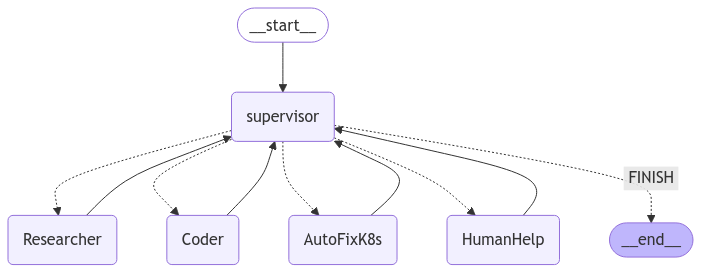

In [8]:
# 定义工作流和 Graph（有向有环图）
# 创建工作流，并且给节点添加 route 路由逻辑

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# auto fix agent
auto_fix_agent = create_react_agent(llm, tools=[auto_fix_k8s])
auto_fix_node = functools.partial(agent_node, agent=auto_fix_agent, name="AutoFixK8s")

# human help agent
human_help_agent = create_react_agent(llm, tools=[human_help])
human_help_node = functools.partial(agent_node, agent=human_help_agent, name="HumanHelp")

# 创建 Graph 并且添加节点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("AutoFixK8s", auto_fix_node)
workflow.add_node("HumanHelp", human_help_node)

# 定义路由逻辑
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass






In [9]:
# 硬编码 Event 测试效果
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="deployment: nginx, namespace: default, event: Back-off pulling image 'nginx:latess'")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'AutoFixK8s'}}
----
{'AutoFixK8s': {'messages': [HumanMessage(content="It seems there was an error while attempting to automatically fix the issue. The error message indicates an `ApiException`, which might be due to a typo in the image name or a network issue while pulling the image.\n\nHere's a possible approach to resolve the issue manually:\n\n1. **Check the Image Name**: Verify that the image name `nginx:latess` is correct. It seems like there might be a typo, as the correct version could be `nginx:latest`.\n\n2. **Edit the Deployment**:\n   ```bash\n   kubectl edit deployment nginx -n default\n   ```\n   - Change the image name from `nginx:latess` to `nginx:latest`.\n\n3. **Save the Changes**: After editing, save and exit the editor. This should automatically trigger a new deployment with the corrected image.\n\n4. **Monitor the Pods**: Check the status of your pods to ensure they are running correctly.\n   ```bash\n   kubectl get pods -n default\n   ```\n

In [10]:
# 硬编码 Event 测试效果
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="deployment: 'unkonw', namespace: 'default', event:  0/3 nodes are available: 1 Insufficient cpu, 2 Insufficient memory.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'AutoFixK8s'}}
----
{'AutoFixK8s': {'messages': [HumanMessage(content='It seems there was an error while trying to automatically fix the Kubernetes issue. The error message indicates an "ApiException," which might be due to incorrect deployment or namespace information.\n\nCould you please verify the deployment name and namespace? It appears there might be a typo in the deployment name ("unkonw"). If you meant "unknown," please confirm or correct it.', additional_kwargs={}, response_metadata={}, name='AutoFixK8s')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='It looks like there was a typo in the deployment name. The correct term should probably be "unknown." \n\nPlease confirm if you meant "unknown" as the deployment name or provide the correct name. Additionally, the namespace "default" seems fine if that\'s where your deployment is supposed to be. Let me know how you\'d like to proceed!', additional_kwa

In [ ]:
# 捕获和处理 K8s 事件
# 监听 K8s 的产生，并且调用 Supervisor 处理事件

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()
core_v1 = client.CoreV1Api()

w = watch.Watch()

def run_stream(message: str):
    for s in graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        }
    ):
        if "__end__" not in s:
            print(s)
            print("----")

try:
    namespace = "default"
    for event in w.stream(
        core_v1.list_namespaced_event, namespace=namespace, _request_timeout=None
    ):
        event_type = event["type"]
        event_object = event["object"]

        # 检查事件类型
        if event_object.type == "Warning":
            involved_object = event_object.involved_object
            pod_name = involved_object.name
            reason = event_object.reason
            message = event_object.message

            print(f"Warning Event: {event_type} {pod_name} - {reason} - {message}")

            # 处理异常：Pod 可能不存在
            try:
                pod = core_v1.read_namespaced_pod(name=pod_name, namespace=namespace)
                deployment_name = pod.metadata.labels.get("app","unknown")
            except client.exceptions.ApiException as e:
                print(f"Error reading Pod {pod_name}: {e}")
                continue
            
            # 传递 Warning 事件到 run_stream()
            try:
                run_stream(f"deployment: {deployment_name}, namespace: {namespace}, event: {reason} - {message}")
                time.sleep(10)
            except Exception as e:
                print(e)
                continue
        else:
            print(f"Ignore non-warning event: {event_object.type} {event_object.reason} - {event_object.message}")
    
finally:
    w.stop()

In [ ]:
# 任务调度给 Researcher Agent
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="预测一下2025年中国经济")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='预测未来经济发展是一项复杂的任务，涉及众多变量和不确定因素。不过，可以基于当前的经济趋势、政策方向和全球环境等因素，对中国2025年的经济前景做出一些初步预测。\n\n1. **经济增长**：预计中国经济将继续保持增长，但增速可能会有所放缓。随着中国经济逐渐转型，消费和服务业可能会成为新的增长动力，而传统的工业和出口导向型经济的重要性可能会逐步下降。\n\n2. **科技与创新**：中国在科技创新领域的投入将继续增加，特别是在人工智能、5G、绿色技术等领域的突破可能会推动经济新一轮增长。\n\n3. **环境与可持续发展**：中国政府对可持续发展的重视程度日益增加，预计在2025年，绿色经济和可再生能源将会有显著的发展，推动经济的绿色转型。\n\n4. **国际贸易与投资**：面对全球贸易格局的变化，中国可能会加大对“一带一路”沿线国家的投资和合作，同时也会加强与其他主要经济体的经贸关系。\n\n5. **人口与社会变化**：人口老龄化问题将对中国的劳动力市场和社会保障体系产生影响，可能需要通过政策调整来应对这些挑战。\n\n这些预测基于现有的信息和趋势，实际情况可能会受到全球经济变化、政策调整和其他不可预见因素的影响而有所不同。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [13]:
# 任务调度给 Coder Agent
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="用python写一段冒泡排序算法")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='这里是一个使用Python实现的冒泡排序算法：\n\n```python\ndef bubble_sort(arr):\n    n = len(arr)\n    for i in range(n):\n        for j in range(0, n-i-1):\n            if arr[j] > arr[j+1]:\n                arr[j], arr[j+1] = arr[j+1], arr[j]\n    return arr\n\n# 测试函数\nsorted_array = bubble_sort([64, 34, 25, 12, 22, 11, 90])\nprint(sorted_array)\n```\n\n测试结果为： `[11, 12, 22, 25, 34, 64, 90]`。', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
